In [3]:
import numpy as np
import scipy

import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm

from matplotlib import animation
%matplotlib notebook  
    
from datetime import datetime
import time

In [4]:
class Evol:
    
    def Mask_s32(self, x):
        if x >= -self.R and x <= -self.R+self.delta_M:
            return -2/self.delta_M**3 * (x+self.R-self.delta_M)**3 \
                   - 3/self.delta_M**2 * (x+self.R-self.delta_M)**2 + 1
        
        elif x >= self.R-self.delta_M and x <= self.R:
            return 2/self.delta_M**3 * (x-self.R+self.delta_M)**3 \
                   - 3/self.delta_M**2 * (x-self.R+self.delta_M)**2 + 1
        
        elif x > -self.R+self.delta_M and x < self.R-self.delta_M:
            return 1.0
        
        else:
            return 0.0
    
    def Mask_exp(self, x):
        return np.exp(-(x/(self.R-self.delta_M))**10)
    
    def Analit_solution(self):
        psi = [np.exp(-self.x[1:-1]**2/(4*(1+1j*self.tau*i))) \
               / (2*np.pi)**(1/4) / (1+1j*self.tau*i) for i in range(self.N_steps)]
        return psi
    
    
    def __init__(self, R, M, delta_M, tau, N_steps):
        self.R = R
        self.M = M
        self.tau = tau
        self.delta_M = delta_M
        self.N_steps = N_steps
        
        self.x = np.linspace(-R, R, M+1)
        self.delta = self.x[1] - self.x[0]
        
        self.psi_0 = np.exp(-self.x[1:-1]**2/4) / (2*np.pi)**(1/4)  # initial condition
        
        # matrices
        diag_T = 2/self.delta**2 * np.ones(M-1)
        subdiag_T = -1/self.delta**2 * np.ones(M-2)
        diags_T = [subdiag_T, diag_T, subdiag_T]
        self.T = scipy.sparse.diags(diags_T,[-1,0,1]).toarray()
        
        self.expiTtau = scipy.linalg.expm(- 1j*self.T*self.tau)
        self.Mask = np.array([self.Mask_s32(self.x[1:-1][i]) for i in range(len(self.x[1:-1]))])        
    
    def solver(self):
        psi_M = self.Mask * self.psi_0
        psi_M_n = []
        for i in range(self.N_steps):
            psi_M_n += [psi_M]
            psi_M = self.Mask * (self.expiTtau @ psi_M)
        
        return psi_M_n
    
    def residual(self):
        psi_an = self.Analit_solution()
        psi_num = self.solver()
        
        return [np.sum(abs(np.absolute(psi_an[i])**2 \
                            - np.absolute(psi_num[i])**2)) for i in range(ev.N_steps)]

<IPython.core.display.Javascript object>


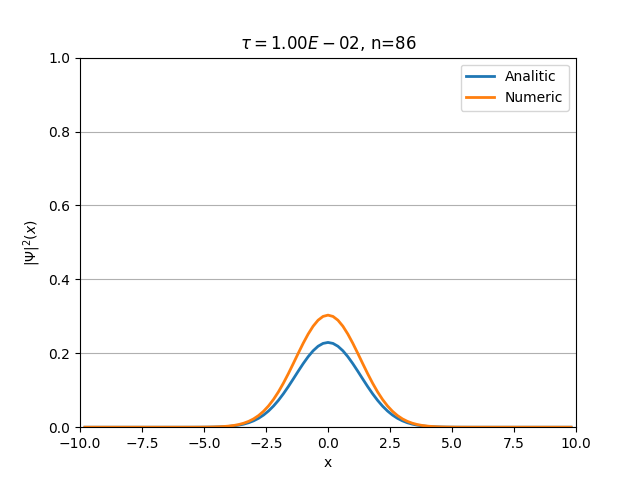

In [6]:
ev = Evol(10.0, 100, 3, 1e-2, 100)

psi_an = ev.Analit_solution()
psi_num = ev.solver()
        
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(-ev.R, ev.R), ylim=(0, None))
line1, = ax.plot([], [], lw=2, label='Analitic')
line2, = ax.plot([], [], lw=2, label='Numeric')
ax.legend()
ax.grid(axis='y')
ax.set_xlabel('x')
ax.set_ylabel(r'$|\Psi|^2(x)$')


# initialization function: plot the background of each frame
def init():
    line1.set_data([], [])
    line2.set_data([], [])
    return line1, line2,

# animation function.  This is called sequentially
def animate(i):
    line1.set_data(ev.x[1:-1], np.absolute(psi_an[i])**2)
    line2.set_data(ev.x[1:-1], np.absolute(psi_num[i])**2)
    ax.set_title(fr'$\tau={ev.tau:>0.2E}$, n={i}')
    return line1, line2,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(psi_num), blit=True)

# # save the animation as an mp4.  This requires ffmpeg or mencoder to be
# # installed.  The extra_args ensure that the x264 codec is used, so that
# # the video can be embedded in html5.  You may need to adjust this for
# # your system: for more information, see
# # http://matplotlib.sourceforge.net/api/animation_api.html
# anim.save('figures/basic_animation.gif', writer='Pillow', fps=30)

plt.show()    

In [147]:
residual = [np.mean(abs(np.absolute(psi_an[i])**2 - np.absolute(psi_num[i])**2)) for i in range(ev.N_steps)]

<IPython.core.display.Javascript object>


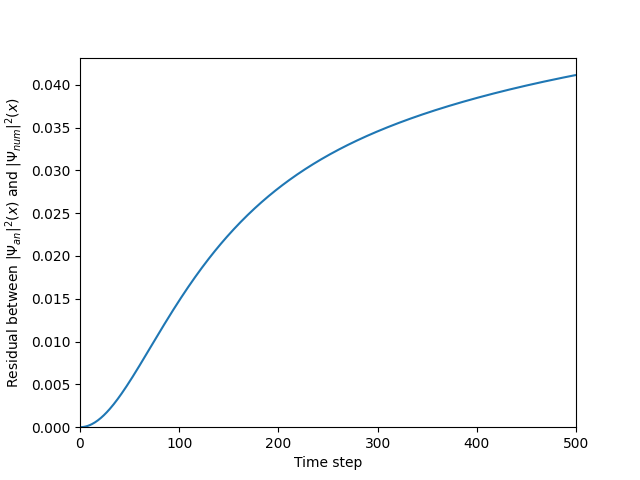

Text(0, 0.5, 'Residual between $|\\Psi_{an}|^2(x)$ and $|\\Psi_{num}|^2(x)$')

In [148]:
plt.plot(np.arange(ev.N_steps), residual)
plt.xlim(0,ev.N_steps)
plt.ylim(0,None)
plt.xlabel('Time step')
plt.ylabel(r'Residual between $|\Psi_{an}|^2(x)$ and $|\Psi_{num}|^2(x)$')